# Bike Sharing Data Challenge

**Author**: Christian Contreras-Campana, Phd

**Date**: June 03, 2018

**Models used:** XGBRegressor, RandomForestRegressor, GradientBoostingRegressor combined with feature selection.

**Feature engineering:** one-hot encoding

**Feature scaling:** standardization (centering and scaling) of dataset that removes mean and scales to unit variance. It is necessary for machine learning estimators.

**Outlier identification:** based on LassoCV it compares rmse with residual of every point predicted vs. actual sale price.

Validation of models by split of training set and plotting predicted vs. actual sale price.


## Introduction

Bike-Share is a bike share service provider where users can take and return bikes at any of the 100 stations on their network. The company wants to leverage their data to better understand and, hopefully, optimize their operations. They are interested in exploring the potential of machine learning to predict the number of bikes taken and returned to each station.

The company would like to use the output of the predictive model to help the logistics team schedule the redistribution of bikes between stations. This in turn will help ensure there are bikes and return docks available when and where users need them.

To arrange this schedule, they need an estimation of the net change in the stock of bikes at a station for the time window between two pick-up/drop-off visits so the station may face the upcoming demand. Naturally, the number of visits will depending on the intensity of the use of that station, the use of other stations in the network, as well as resources available.

As a first step towards tackling this challenge, we are to develop a model capable of outputing the net rate of bike renting for a given station (i.e. net rate is defined as trips ended minus trips started at the station for a given hour). That is, at any time the logistic department of the company should be able to make a statement such as "In the next hour, the net stock of bikes at a station A will change by X."

Results will be accompanied by the root-mean-square error (RMSE) metric as a measure of the performance of each model. But we should keep in mind that RMSE has zero tolerance for outlier data points which don't belong. RMSE relies on all data being right and all are counted as equal. That means one stray point that's way out in left field is going to totally ruin the whole calculation.

In [145]:
from __future__ import print_function

# standard libraries
import os
import math

from functools import partial

# numpy library
import numpy as np

# matplotlib libraries
import matplotlib.pyplot as plt

# pandas library
import pandas
import pandas as pd

# sci-kit learn libraries
import sklearn

from sklearn.linear_model import (LinearRegression, Lars,
                                  BayesianRidge, Lasso, Ridge, ElasticNet,
                                  RidgeCV, LassoCV, ElasticNetCV, LarsCV
                                  )

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import (KFold, GridSearchCV, 
                                     train_test_split, learning_curve)

from sklearn.preprocessing import (StandardScaler, RobustScaler, MinMaxScaler,
                                   LabelEncoder, OneHotEncoder)

from sklearn.pipeline import make_pipeline

from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error, make_scorer

from xgboost import XGBRegressor

from skrebate import ReliefF, SURF, SURFstar, MultiSURF, MultiSURFstar, TuRF
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

from feature_selector import FeatureSelector
import pymrmr

import shap

from collections import OrderedDict

In [2]:
# Fix random seed for reproducibility
seed = 42
np.random.seed(seed)
verbose   = 2

In [3]:
# City zip codes
zip_code = {'San Francisco': 94107, 'Redwood City': 94063, 
            'Palo Alto': 94301, 'Mountain View': 94041, 
            'San Jose': 95113}
   
# New station IDs for changed stations
map_to_old_id = {85: 23, 86: 25, 87: 49, 88: 69, 89: 72, 90: 72}

In [4]:
# Extract estimator name
def extract_estimator_name(estimator):

    # check to see if estimator is a pipeline object or not
    if isinstance(estimator, sklearn.pipeline.Pipeline):
        data_type = type(estimator._final_estimator)

    # check to see if estimator is a grid search object or not
    elif isinstance(estimator, sklearn.model_selection._search.GridSearchCV):
        # check to see if estimator is a pipeline object or not
        if isinstance(estimator.best_estimator_, sklearn.pipeline.Pipeline):
            data_type = type(estimator.best_estimator_._final_estimator)

        else:
            data_type = type(estimator.best_estimator_)

    # object is not a pipeline or grid search estimator
    else:
        data_type = type(estimator)

    name = ''.join(filter(str.isalnum, str(data_type).split('.')[-1]))

    return name

In [5]:
# Standard nested k-fold cross validation
def grid_search(estimator, X, y, outer_cv, inner_cv,
                param_grid, scoring='accuracy',
                n_jobs=1, debug=False):
    """
    Nested k-fold cross-validation

    Parameters
    ----------
    estimator : array, shape = [n_samples]
         true class, integers in [0, n_classes - 1)
    X : array,   shape = [n_samples, n_classes]
    y : array,   shape = [n_samples, n_classes]
    outer_cv :   shape = [n_samples, n_classes]
    inner_cv :   shape = [n_samples, n_classes]
    param_grid : shape = [n_samples, n_classes]
    scoring :    shape = [n_samples, n_classes]
    n_jobs : int, default 1
    debug : boolean, default Fasle

    Returns
    -------
    grid : GridSearchCV object
        A post-fit (re-fitted to full dataset) GridSearchCV 
        object where the estimator is a Pipeline.
    """

    outer_scores = []

    # Extract model name
    name = extract_estimator_name(estimator).lower()

    # Set up grid search configuration
    grid = GridSearchCV(estimator=estimator, param_grid=param_grid,
                        cv=inner_cv, scoring=scoring, n_jobs=n_jobs)

    # Set aside a hold-out test data for model evaluation
    for k, (training_samples, test_samples) in enumerate(outer_cv.split(X, y)):

        # x training and test data
        if isinstance(X, pd.DataFrame):
            x_train = X.iloc[training_samples]
            x_test = X.iloc[test_samples]

        # in case of spare matrices
        else:
            x_train = X[training_samples]
            x_test = X[test_samples]

        # y training and test data
        if isinstance(y, pd.Series):
            y_train = y.iloc[training_samples]
            y_test = y.iloc[test_samples]

        # in case of numpy arrays
        else:
            y_train = y[training_samples]
            y_test = y[test_samples]

        # Build classifier on best parameters using outer training set
        # Fit model to entire training data (i.e tuning & validation dataset)
        print('fold-', k+1, 'model fitting...')

        # Train on the training set
        grid.fit(x_train, y_train)

        # Hyper-parameters of the best model
        if debug:
            print('\n\t', grid.best_estimator_.get_params()[name])

        # Evaluate
        score = grid.score(x_test, y_test)

        outer_scores.append(abs(score))
        print('\n\tModel validation score:', abs(score), '\n')

    # Print hyper-parameters of best model
    print('\nHyper-paramters of best model:\n\n',
          grid.best_estimator_.get_params()[name])

    # Print final model evaluation (i.e. mean cross-validation scores)
    print('\nFinal model evaluation (mean cross-val scores):',
          np.array(outer_scores).mean())

    return grid

In [6]:
# Define learning curve plot
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        scoring=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    scoring : string

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).

    train_sizes : array-like
    """
    
    train_sizes, train_scores, test_scores = learning_curve(
                 estimator, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs,
                 train_sizes=train_sizes)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    # Set figure size before plotting
    plt.figure(figsize=(8, 6))
        
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color='r')
    
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color='g')
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r',
             label='Training score')
    
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g',
             label='Cross-validation score')
    
    plt.title(title)
        
    plt.xlabel('Training sample size')
    plt.ylabel('Score: '+scoring)
    
    if ylim is not None:
        plt.ylim(*ylim)
    
    plt.legend(loc='best')
    
    return display(plt.show())


In [7]:
# Define error measure for official scoring : RMSE
def rmse_cv(model, X, y, scorer='neg_mean_squared_error'):
    rmse= np.sqrt(-cross_val_score(model, 
                                   X, y, 
                                   scoring=scorer, 
                                   cv = 3))
    return rmse

In [8]:
def f_sine(t, T): return math.sin(2*math.pi*t/T)
def f_cosine(t, T): return math.cos(2*math.pi*t/T)

##  Load Data

The data set is ingested and feature names are relabeled to ease data manipulation.

In [9]:
# Load datation data
station_data = pd.read_csv(filepath_or_buffer='data/station_data.csv',
                           sep=',', header=0,
                           names=['Station', 'Name', 'Lat', 'Long', 'Dock_Count', 'City'])

# Size of station data
print('dimensions of station data:',station_data.shape)

# Check to see if station data has any missing values
# Note: false means no data is missing
print('check if any data is missing:', 
      station_data.isnull().values.any())

# Print out a few samples from station dataset
station_data.head(5)

dimensions of station data: (76, 6)
check if any data is missing: False


,Station,Name,Lat,Long,Dock_Count,City
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose


In [10]:
# Load datation data
station_data = pd.read_csv(filepath_or_buffer='data/station_data.csv',
                           sep=',', header=0,
                           names=['Station', 'Name', 'Lat', 'Long', 'Dock_Count', 'City'])

# Size of station data
print('dimensions of station data:',station_data.shape)

# Check to see if station data has any missing values
# Note: false means no data is missing
print('check if any data is missing:', 
      station_data.isnull().values.any())

# Print out a few samples from station dataset
station_data.head(5)

dimensions of station data: (76, 6)
check if any data is missing: False


,Station,Name,Lat,Long,Dock_Count,City
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose


In [11]:
# Load trip data
trip_data = pd.read_csv(filepath_or_buffer='data/trip_data.csv', sep=',',
                        header=0, infer_datetime_format=True, dayfirst=True,
                        parse_dates=['Start_Date', 'End_Date'],
                        names=['Trip_ID', 'Start_Date', 'Start_Station',
                               'End_Date', 'End_Station', 'Subscriber_Type'])

# Size of trip data
print('dimension of trip data:',trip_data.shape)

# Check to see if trip data has any missing values
# Note: false means no data is missing
print('check if any data is missing:',trip_data.isnull().values.any())

# Print out a few samples from trip dataset
trip_data.head(5)

dimension of trip data: (354152, 6)
check if any data is missing: False


,Trip_ID,Start_Date,Start_Station,End_Date,End_Station,Subscriber_Type
0,913460,2015-08-31 23:26:00,50,2015-08-31 23:39:00,70,Subscriber
1,913459,2015-08-31 23:11:00,31,2015-08-31 23:28:00,27,Subscriber
2,913455,2015-08-31 23:13:00,47,2015-08-31 23:18:00,64,Subscriber
3,913454,2015-08-31 23:10:00,10,2015-08-31 23:17:00,8,Subscriber
4,913453,2015-08-31 23:09:00,51,2015-08-31 23:22:00,60,Customer


In [12]:
# Load weather data
weather_data = pd.read_csv(filepath_or_buffer='data/weather_data.csv',
                           sep=',', infer_datetime_format=True, 
                           dayfirst=True,
                           parse_dates=['Date'])

# Size of trip data
print('dimension of trip data:', weather_data.shape)

# Check to see if weather data has any missing values
# Note: false means no data is missing
print('check if any data is missing:', weather_data.isnull().values.any())

# Print out a few samples from weather dataset
weather_data.head(5)

dimension of trip data: (1825, 24)
check if any data is missing: True


,Date,Max TemperatureF,Mean TemperatureF,Min TemperatureF,Max Dew PointF,MeanDew PointF,Min DewpointF,Max Humidity,Mean Humidity,Min Humidity,...,Mean VisibilityMiles,Min VisibilityMiles,Max Wind SpeedMPH,Mean Wind SpeedMPH,Max Gust SpeedMPH,PrecipitationIn,CloudCover,Events,WindDirDegrees,Zip
0,2014-09-01,83.0,70.0,57.0,58.0,56.0,52.0,86.0,64.0,42.0,...,10.0,8.0,16.0,7.0,20.0,0.0,0.0,NaN,290.0,94107
1,2014-09-02,72.0,66.0,60.0,58.0,57.0,55.0,84.0,73.0,61.0,...,10.0,7.0,21.0,8.0,NaN,0.0,5.0,NaN,290.0,94107
2,2014-09-03,76.0,69.0,61.0,57.0,56.0,55.0,84.0,69.0,53.0,...,10.0,10.0,21.0,8.0,24.0,0.0,4.0,NaN,276.0,94107
3,2014-09-04,74.0,68.0,61.0,57.0,57.0,56.0,84.0,71.0,57.0,...,10.0,8.0,22.0,8.0,25.0,0.0,5.0,NaN,301.0,94107
4,2014-09-05,72.0,66.0,60.0,57.0,56.0,54.0,84.0,71.0,57.0,...,9.0,7.0,18.0,8.0,32.0,0.0,4.0,NaN,309.0,94107


## Data Cleaning

The data my have missing values and for this reason we perform some basic data cleaning.

In [13]:
# Types of events
set(weather_data['Events'])

{nan, 'Fog', 'Fog-Rain', 'Rain', 'Rain-Thunderstorm'}

In [14]:
# Fill Events with NaN values with 'Clear'
weather_data['Events'] = weather_data['Events'].fillna('Clear')

- We fill in missing values for temperature, wind, and percipitation since these are features that will most likely affect a person when deciding to rent a bike.

- It appears that the weather data has missing values. For example, the "Events" feature has NaN values but some of the other features like "Max Gust SpeedMPH" also have missing values. We may need to fill in some of the missing values only if we decide to use any features which may have a small fraction of missing values.

- Missing weather information will be filled with its average value across the five locations for a given day of the year.

In [15]:
# Fill missing weather information with mean value
mean_weather_data = weather_data.set_index(['Date'])\
                                .sort_index()\
                                .groupby(level=['Date']).mean()
        
weather_data = weather_data.set_index(['Date'])\
                           .sort_index()\
                           .fillna(value=mean_weather_data, axis=0)

There is still missing weather information for Max Gust SpeedMPH for days in which all cities had no recorded values, and therefore an average value could not be determined. To resolve this issue we will interpolate the missing Max Gust SpeendMPH by looking at what the value was in the days before and after the the missing dates.

In [16]:
weather_data = weather_data.sort_index()\
                           .interpolate(method='time')\
                           .reset_index()

## Data Transformations

We map the city names in the station data to the corresponding city zip code.

In [17]:
# Find zip code from city name
station_data['Zip'] = station_data['City'].map(zip_code)

# Drop unecessary columns
station_data.drop(['Name', 'Lat', 'Long', 'City'], inplace=True, axis=1)

We replace the new station IDs with the old station IDs so they can be considered as one place instead of as two places by the machine learning algorithms.

In [18]:
# Map new station IDs to old station IDs
station_data['Station'].replace(to_replace=map_to_old_id, inplace=True)
  
trip_data['Start_Station'].replace(to_replace=map_to_old_id, inplace=True)
    
trip_data['End_Station'].replace(to_replace=map_to_old_id, inplace=True)

# Drop duplicate rows that are produced as a result
# of mapping new station ID to old station ID
station_data.drop_duplicates(inplace=True)

## Data Aggregation

The principle focus of this challenge is understanding the net rate of bike renting for a given station. For this we will need to aggregate the data to estimate the total number of bikes taken and returned for every station at different hours of the day and on different dates.

In [19]:
# Create a multi-index of station ID and trip date (hour level precision)

# https://stackoverflow.com/questions/28132668/
# how-can-i-keep-this-pandas-column-type-as-datetime-when-using-multiindex
idx = pd.MultiIndex\
        .from_product([station_data['Station'].sort_values().unique(),
                       pd.Index(pd.date_range('2014-09-01 00:00:00',
                                             '2015-08-31 23:00:00', 
                                             freq='H'))],
                      names=['Station', 'Datetime'])

In [20]:
# Resampling of time series data by the hour
end_trip_data = trip_data.groupby(['End_Station'])\
                         .resample('H', on='End_Date')\
                         .size().to_frame().rename(columns={0: 'num_trips'})\
                         .reindex(idx, fill_value=0)

start_trip_data = trip_data.groupby(['Start_Station'])\
                            .resample('H', on='Start_Date')\
                            .size().to_frame().rename(columns={0: 'num_trips'})\
                            .reindex(idx, fill_value=0)

The end and start trip data are merged to give us an overall view of what occurs at every station on different dates and at different hours.

In [21]:
# Merge end trip and start trip data
trip_data_agg = end_trip_data.merge(start_trip_data,
                                    left_index=True, right_index=True,
                                    suffixes=('_end', '_start'))

For example, on 2014-09-02 at 7 in the morning at station 2 six trips ended and three trips were started.

In [22]:
# Check aggrated trip data table
display(trip_data_agg.iloc[range(31,35)])

num_trips_end  num_trips_start
Station Datetime                                           
2       2014-09-02 07:00:00              6                3
        2014-09-02 08:00:00              1                2
        2014-09-02 09:00:00              2                3
        2014-09-02 10:00:00              0                0

In [23]:
# Extract Date information
trip_data_agg['Date'] = pd.Series(trip_data_agg.index.get_level_values('Datetime').date)\
                          .apply(pd.Timestamp).to_frame().set_index(idx)

# Extract Hour information
trip_data_agg['Hour'] = trip_data_agg.index.get_level_values('Datetime').hour.values

## Net Rate

Proceeding with the net rate estimation. This will be our target response for our machine learning algorithms.

In [24]:
# Calcuate net rate
trip_data_agg.eval('net_rate=num_trips_end-num_trips_start', inplace=True)

# Remove columns that are of no longer use
trip_data_agg.drop(['num_trips_end', 'num_trips_start'], inplace=True, axis=1)

## Data Augmentation

The bike station and weather data can be joined with our previous aggregated trip data. The advantage of this is that we will have a more granular picture of the physical location and therefore allow us to investigate how environmental effects influence the demand on bike rentals.

In [25]:
# Join aggregated trip data with station data
trip_data_agg = trip_data_agg.join(station_data.set_index('Station'))

In [26]:
# Join aggregated trip data with weather data
trip_data_agg.reset_index(inplace=True)
trip_data_agg.set_index(['Date', 'Zip'], inplace=True)

weather_data.set_index(['Date', 'Zip'], inplace=True)

trip_data_agg = trip_data_agg.join(weather_data)\
                             .reset_index()\
                             .set_index(['Station', 'Datetime'])

## Data Exploration

Now that we have the data at our disposal we can explore it to find any trends or features that may help us better model our problem. We view the mean net rate across all stations for the different hours.

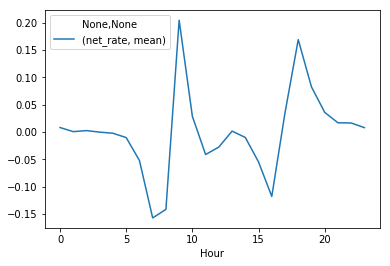

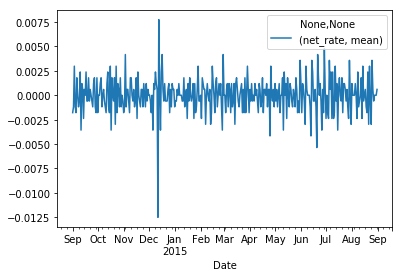

In [27]:
trip_data_agg.groupby(['Hour']).agg({'net_rate': ['mean']}).plot();
trip_data_agg.groupby(['Date']).agg({'net_rate': ['mean']}).plot();

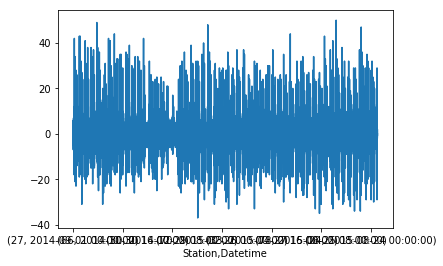

In [28]:
trip_data_agg['net_rate'].plot()

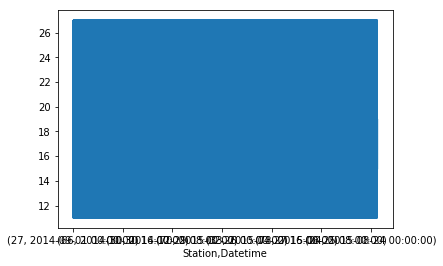

In [34]:
trip_data_agg['Dock_Count'].plot()

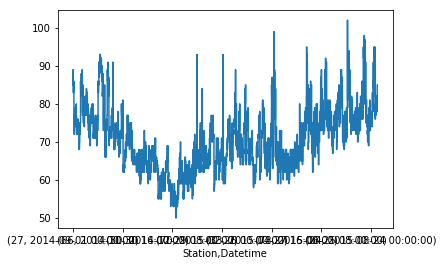

In [35]:
trip_data_agg['Max TemperatureF'].plot()

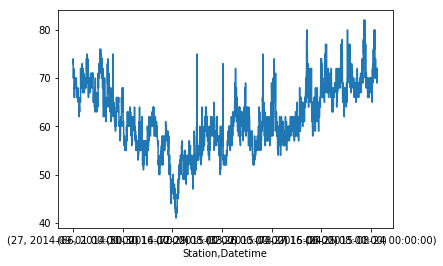

In [36]:
trip_data_agg['Mean TemperatureF'].plot()

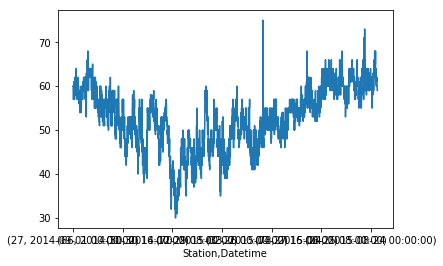

In [37]:
trip_data_agg['Min TemperatureF'].plot()

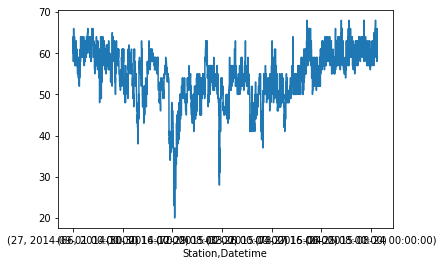

In [38]:
trip_data_agg['Max Dew PointF'].plot()

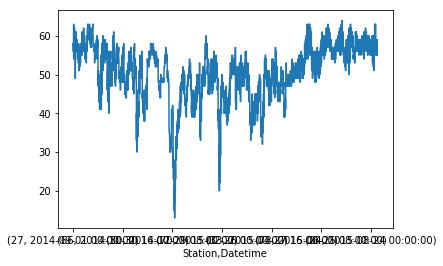

In [39]:
trip_data_agg['MeanDew PointF'].plot()

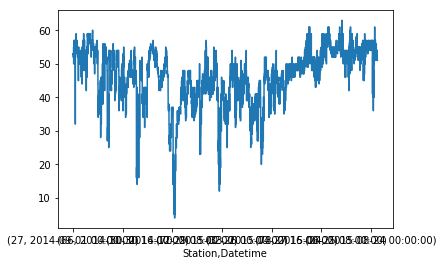

In [40]:
trip_data_agg['Min DewpointF'].plot()

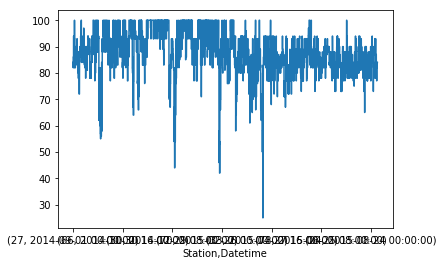

In [41]:
trip_data_agg['Max Humidity'].plot()

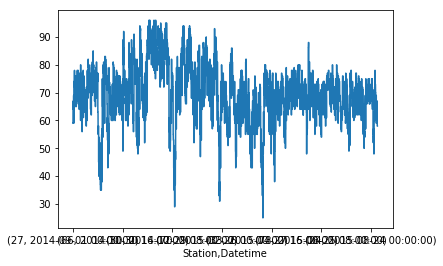

In [42]:
trip_data_agg['Mean Humidity'].plot()

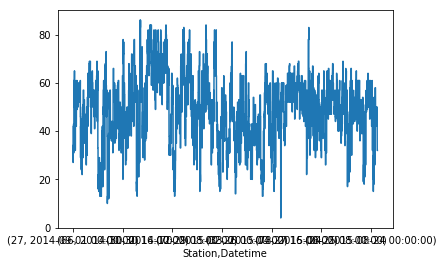

In [43]:
trip_data_agg['Min Humidity'].plot()

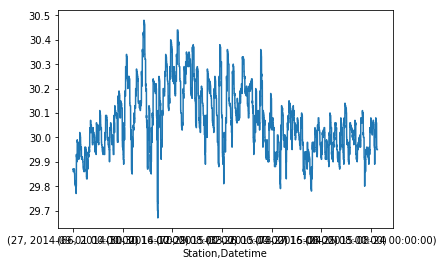

In [44]:
trip_data_agg['Max Sea Level PressureIn'].plot()

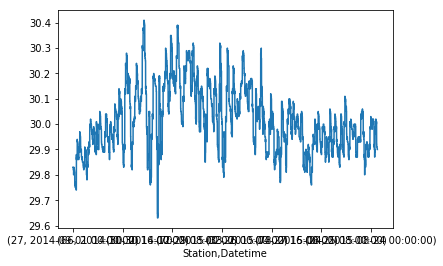

In [45]:
trip_data_agg['Mean Sea Level PressureIn'].plot()

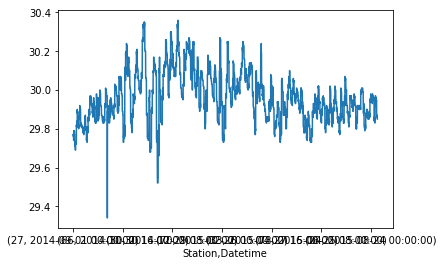

In [46]:
trip_data_agg['Min Sea Level PressureIn'].plot()

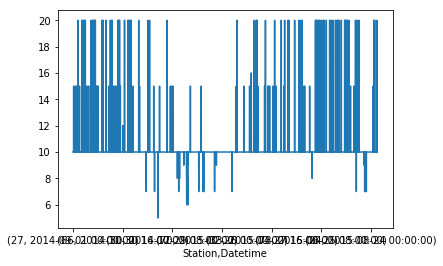

In [47]:
trip_data_agg['Max VisibilityMiles'].plot()

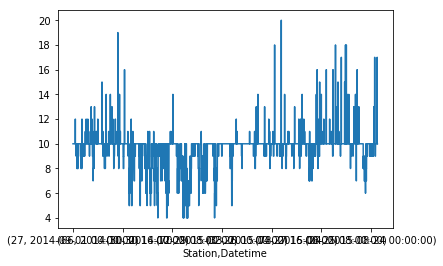

In [48]:
trip_data_agg['Mean VisibilityMiles'].plot()

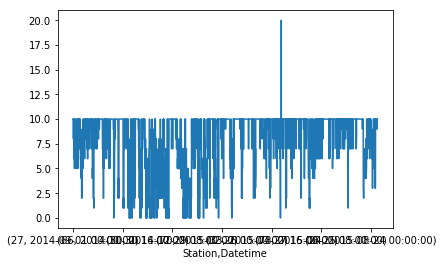

In [49]:
trip_data_agg['Min VisibilityMiles'].plot()

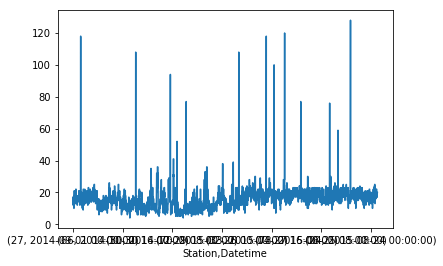

In [50]:
trip_data_agg['Max Wind SpeedMPH'].plot()

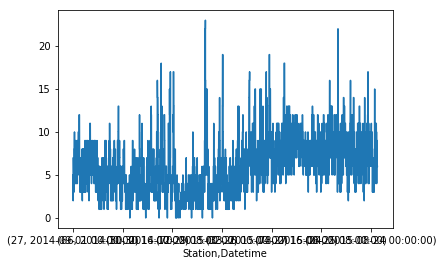

In [51]:
trip_data_agg['Mean Wind SpeedMPH'].plot()

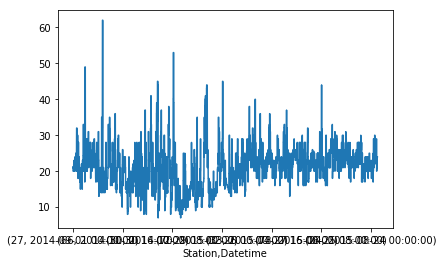

In [52]:
trip_data_agg['Max Gust SpeedMPH'].plot()

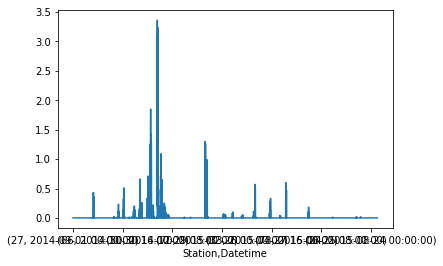

In [53]:
trip_data_agg['PrecipitationIn'].plot()

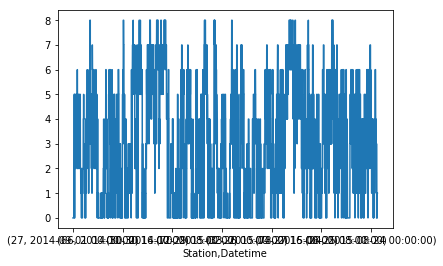

In [54]:
trip_data_agg['CloudCover'].plot()

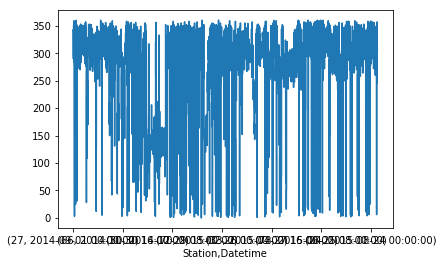

In [56]:
trip_data_agg['WindDirDegrees'].plot()

In [ ]:
# Eample
#df.groupby("country")['unemployment'].mean().plot(kind='bar')

## Feature Enginnering

Given the aggregated data we may engineer a series of features that may improve the performance of the predictive model. We explore temporal features, lagged features, cyclic ordinal features, and categorical features.

In [28]:
# New feature that identifies whether the person was a customer or a subscriber
trip_data = trip_data.join(pd.get_dummies(trip_data['Subscriber_Type']))

# Remove redundant feature
trip_data.drop(['Subscriber_Type'], inplace=True, axis=1)

## Temporal Features

In [29]:
# Determine whether the hour of day is night or not
trip_data_agg['Is_night'] = trip_data_agg['Hour'].apply(lambda h: 1 if h < 5 or h > 20 else 0)

In [30]:
# Determine if day is weekday or weekend
trip_data_agg['Day_of_week'] = trip_data_agg['Date'].apply(lambda dt: dt.weekday())

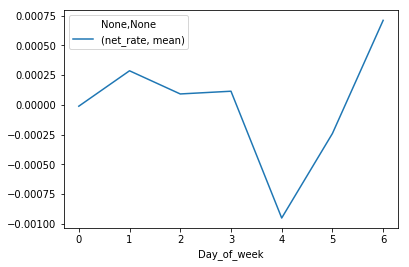

In [31]:
trip_data_agg.groupby(['Day_of_week']).agg({'net_rate': ['mean']}).plot()

In [32]:
# Determine if day is weekday or weekend
trip_data_agg['Is_weekday'] = trip_data_agg['Day_of_week']\
        .apply(lambda s: 0 if s in [5, 6] else 1)

In [33]:
# Establish season: winter (0), spring (1), summer (2), fall (3)
trip_data_agg['Season'] = trip_data_agg['Date'].apply(lambda dt: (dt.month%12 + 3)//3-1)

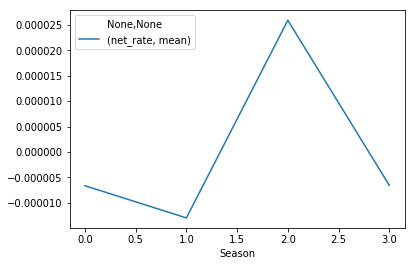

In [34]:
trip_data_agg.groupby(['Season']).agg({'net_rate': ['mean']}).plot()

### Lagged Features

We also keep track of how many customers and subscribers used the station. It may be beneficial to know the number of customers and subcribers that use the various bike stations at different hours of the day. The composition of customers and subscribers may help us understand which of the two types of clients has greater influence on bike rentals for each location.

In [35]:
# Number of end customers
end_trip_data = trip_data.groupby(['End_Station'])\
              .resample('H', on='End_Date')\
              .sum()\
              .reindex(idx, fill_value=0)\
              .drop(['Trip_ID', 'Start_Station',
                     'End_Station'], axis=1)

# Number of start subscribers
start_trip_data = trip_data.groupby(['Start_Station'])\
              .resample('H', on='Start_Date')\
              .sum()\
              .reindex(idx, fill_value=0)\
              .drop(['Trip_ID', 'End_Station',
                    'Start_Station'], axis=1)

# Calculate net customers and subscribers
trip_data_agg = trip_data_agg.join(end_trip_data)\
                             .join(start_trip_data, lsuffix='_end', rsuffix='_start')
    
trip_data_agg.eval('net_customers=Customer_end+Customer_start', inplace=True)
trip_data_agg.eval('net_subscribers=Subscriber_end+Subscriber_start', inplace=True)

# Remove columns that are of no longer use
trip_data_agg.drop(['Customer_end', 'Subscriber_end', 
                    'Customer_start', 'Subscriber_start'], inplace=True, axis=1)

We now engineer time lagged features (i.e. by one hour).

In [36]:
# Net rate of the previous hour
trip_data_agg['net_rate_previous_hour'] = \
        trip_data_agg.groupby(['Station', 'Date'])['net_rate']\
                .shift(1).fillna(0)

# Net customers of the previous hour
trip_data_agg['net_customers_previous_hour'] = \
        trip_data_agg.groupby(['Station', 'Date'])['net_customers']\
                .shift(1).fillna(0)

# Net subscribers of the previous hour
trip_data_agg['net_subscribers_previous_hour'] = \
        trip_data_agg.groupby(['Station', 'Date'])['net_subscribers']\
                .shift(1).fillna(0)
        
# Drop columns that of no longer use
trip_data_agg.drop(['net_customers',  'net_subscribers'], inplace=True, axis=1)

### Cyclic Ordinal Features

In [37]:
# Convert Hour to cyclic value
partial_sine = partial(f_sine, T=23)
partial_cosine = partial(f_cosine, T=23)

trip_data_agg['Hour_sine'] = trip_data_agg['Hour'].apply(partial_sine)
trip_data_agg['Hour_cosine'] = trip_data_agg['Hour'].apply(partial_cosine)

# Convert Day of week to cyclic value
partial_sine = partial(f_sine, T=6)
partial_cosine = partial(f_cosine, T=6)

trip_data_agg['Day_of_week_sine'] = trip_data_agg['Day_of_week'].apply(partial_sine)
trip_data_agg['Day_of_week_cosine'] = trip_data_agg['Day_of_week'].apply(partial_cosine)

# Convert Season to cyclic value
partial_sine = partial(f_sine, T=3)
partial_cosine = partial(f_cosine, T=3)

trip_data_agg['Season_sine'] = trip_data_agg['Season'].apply(partial_sine)
trip_data_agg['Season_cosine'] = trip_data_agg['Season'].apply(partial_cosine)

### One-hot Encoding of Categorical Features

In [38]:
# One-hot Encode Events
trip_data_agg = trip_data_agg.join(pd.get_dummies(trip_data_agg['Events']))

# One-hot Encode Station IDs
trip_data_agg.reset_index(inplace=True)

trip_data_agg = trip_data_agg.join(pd.get_dummies(trip_data_agg['Station'], prefix='Station'))

# One-hot Encode Zip code
trip_data_agg = trip_data_agg.join(pd.get_dummies(trip_data_agg['Zip'], prefix='Zip'))


In [39]:
# Drop columns that of no longer use
trip_data_agg.drop(['Events',  'Station', 'Zip','Hour', 
                    'Day_of_week', 'Season', 'Datetime', 'Date'], 
                   inplace=True, axis=1)

In [40]:
# SOURCE: https://www.kaggle.com/mburakergenc/predictions-with-xgboost-and-linear-regression
# Check any number of columns with NaN
print(trip_data_agg.isnull().any().sum(), ' / ', len(trip_data_agg.columns))

# Check any number of data points with NaN
print(trip_data_agg.isnull().any(axis=1).sum(), ' / ', len(trip_data_agg))

0  /  114
0  /  613200


The following are the features of interest.

In [41]:
feature_names = [# Engineered features
                 'Hour_cosine',
                 'Hour_sine',
                 'Day_of_week_cosine',
                 'Day_of_week_sine',
                 'Is_weekday',
                 'Is_night',
                 # Seasonal-base engineered features
                 'Season_cosine',
                 'Season_sine',
                 # Net-rate based egineered features
                 'net_rate_previous_hour',
                 'net_customers_previous_hour',
                 'net_subscribers_previous_hour',
                 # Weather-based features
                 'Dock_Count',
                 'Fog',
                 'Fog-Rain',
                 'Clear',
                 'Rain',
                 'Rain-Thunderstorm',
                 'CloudCover',
                 'PrecipitationIn',
                 'WindDirDegrees',
                 # Maximum-based weather features
                 'Max Dew PointF',
                 'Max Gust SpeedMPH',
                 'Max Humidity',
                 'Max Sea Level PressureIn',
                 'Max TemperatureF',
                 'Max VisibilityMiles',
                 'Max Wind SpeedMPH',
                 # Mean-based weather features
                 'Mean Humidity',
                 'Mean Sea Level PressureIn',
                 'Mean TemperatureF',
                 'Mean VisibilityMiles',
                 'Mean Wind SpeedMPH',
                 'MeanDew PointF',
                 # Minimum-based wheather features
                 'Min DewpointF',
                 'Min Humidity',
                 'Min Sea Level PressureIn',
                 'Min TemperatureF',
                 'Min VisibilityMiles',
                 # Zipcode-based features
                 'Zip_94041',
                 'Zip_94063',
                 'Zip_94107',
                 'Zip_94301',
                 'Zip_95113',
                 # Station-based features
                 'Station_10',
                 'Station_11',
                 'Station_12',
                 'Station_13',
                 'Station_14',
                 'Station_16',
                 'Station_2',
                 'Station_21',
                 'Station_22',
                 'Station_23',
                 'Station_24',
                 'Station_25',
                 'Station_26',
                 'Station_27',
                 'Station_28',
                 'Station_29',
                 'Station_3',
                 'Station_30',
                 'Station_31',
                 'Station_32',
                 'Station_33',
                 'Station_34',
                 'Station_35',
                 'Station_36',
                 'Station_37',
                 'Station_38',
                 'Station_39',
                 'Station_4',
                 'Station_41',
                 'Station_42',
                 'Station_45',
                 'Station_46',
                 'Station_47',
                 'Station_48',
                 'Station_49',
                 'Station_5',
                 'Station_50',
                 'Station_51',
                 'Station_54',
                 'Station_55',
                 'Station_56',
                 'Station_57',
                 'Station_58',
                 'Station_59',
                 'Station_6',
                 'Station_60',
                 'Station_61',
                 'Station_62',
                 'Station_63',
                 'Station_64',
                 'Station_65',
                 'Station_66',
                 'Station_67',
                 'Station_68',
                 'Station_69',
                 'Station_7',
                 'Station_70',
                 'Station_71',
                 'Station_72',
                 'Station_73',
                 'Station_74',
                 'Station_75',
                 'Station_76',
                 'Station_77',
                 'Station_8',
                 'Station_80',
                 'Station_82',
                 'Station_83',
                 'Station_84',
                 'Station_9',
]

target_name='net_rate'

The models will be using k-fold cross-validation.

In [42]:
# Stratified K-Fold cross-validation
k_fold = 3

outer_kfold_cv = KFold(n_splits=k_fold, random_state=seed)
inner_kfold_cv = KFold(n_splits=k_fold-1, random_state=seed)

In [43]:
# Set data
X = trip_data_agg[feature_names]
y = trip_data_agg[target_name]

In [44]:
# Split data into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.20,
                                                    random_state=seed)

In [45]:
# summarize split
print('Train data rows = %d, columns = %d' % (X_train.shape[0], X_train.shape[1]))
print('Test data rows = %d, columns = %d' % (X_test.shape[0], X_test.shape[1]))

Train data rows = 490560, columns = 113
Test data rows = 122640, columns = 113


### Feature selection

 five methods used to identify features to remove:

- Missing Values
- Single Unique Values
- Collinear Features
- Zero Importance Features
- Low Importance Features

In [76]:
# Features are in train and labels are in train_labels
fs = FeatureSelector(data = X_train, labels = y_train)

In [77]:
# Running all Methods at Once
fs.identify_all(selection_params = {'missing_threshold': 0.5, 
                                    'correlation_threshold': 0.7, 
                                    'task': 'regression', 
                                    'eval_metric': 'l2',
                                    'cumulative_importance': 0.9})

0 features with greater than 0.50 missing values.

0 features with a single unique value.

11 features with a correlation magnitude greater than 0.70.

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 1.37775
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 1.37291
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[996]	valid_0's l2: 1.36647
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 1.37416
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[998]	valid_0's l2: 1.35914
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[1000]

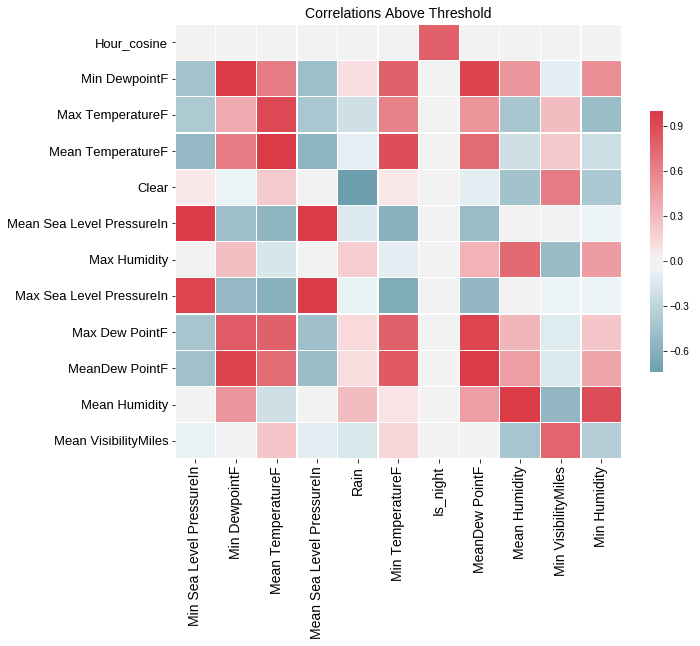

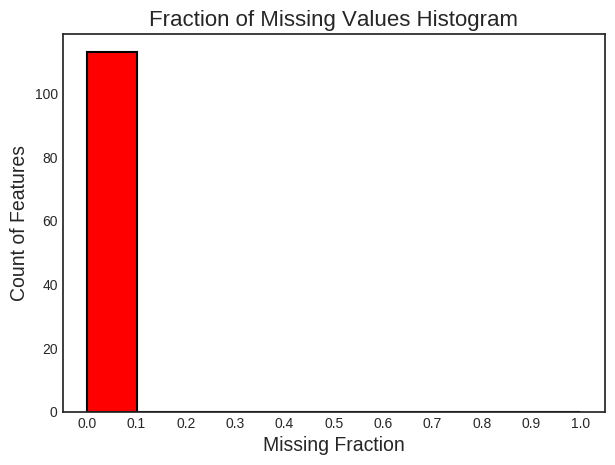

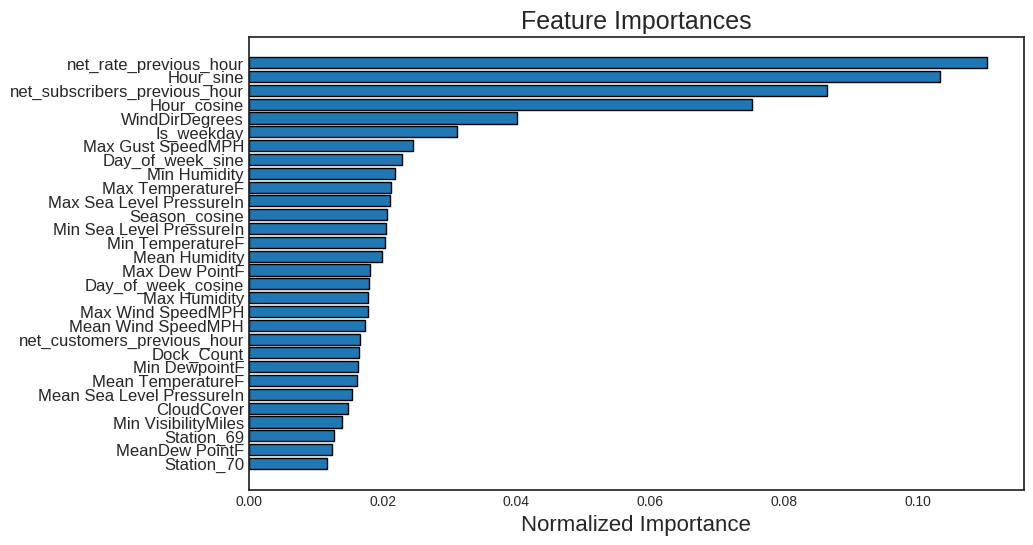

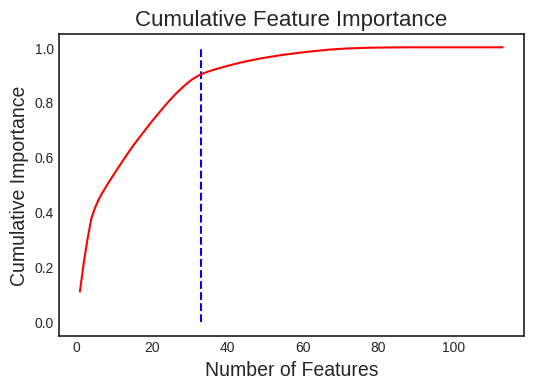

33 features required for 0.90 of cumulative importance


In [78]:
# A neat visualization we can make with correlations is a heatmap. 
# This shows all the features that have at least one correlation above the threshold:
fs.plot_collinear()

# Plot missing Values
fs.plot_missing()

# plot the feature importances
fs.plot_feature_importances(threshold = 0.90, plot_n = 30)

In [79]:
fs.data_all.head()

,Hour_cosine,Hour_sine,Day_of_week_cosine,Day_of_week_sine,Is_weekday,Is_night,Season_cosine,Season_sine,net_rate_previous_hour,net_customers_previous_hour,...,Station_74,Station_75,Station_76,Station_77,Station_8,Station_80,Station_82,Station_83,Station_84,Station_9
416792,-0.576680,0.816970,-1.0,1.224647e-16,1,0,-0.5,8.660254e-01,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
127018,-0.917211,0.398401,0.5,-8.660254e-01,0,0,1.0,-2.449294e-16,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
150493,-0.917211,-0.398401,0.5,-8.660254e-01,0,0,1.0,-2.449294e-16,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
349614,-0.068242,0.997669,0.5,-8.660254e-01,0,0,-0.5,8.660254e-01,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
8838,-0.068242,0.997669,0.5,-8.660254e-01,0,0,1.0,-2.449294e-16,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [80]:
data_removed = fs.remove(methods = 'all', keep_one_hot=False)
missing_features = fs.ops['missing']
missing_features[:5]

['collinear', 'single_unique', 'zero_importance', 'low_importance', 'missing'] methods have been run

Removed 90 features including one-hot features.


[]

In [81]:
# Missing Values
print(fs.missing_stats.head(5))

             missing_fraction
Hour_cosine               0.0
Station_28                0.0
Station_56                0.0
Station_55                0.0
Station_54                0.0


In [82]:
# Collinear features are features that are highly correlated with one another. 
fs.identify_collinear(correlation_threshold = 0.90)

5 features with a correlation magnitude greater than 0.90.



In [83]:
# As before, we can access the entire list of correlated features that will be removed, or see the highly correlated pairs of features in a dataframe.
# list of collinear features to remove
collinear_features = fs.ops['collinear']

In [84]:
# dataframe of collinear features
fs.record_collinear.head(len(feature_names))

,corr_feature,corr_value,drop_feature
0,Max Sea Level PressureIn,0.981388,Mean Sea Level PressureIn
1,Max TemperatureF,0.911837,Mean TemperatureF
2,Max Dew PointF,0.934253,MeanDew PointF
3,MeanDew PointF,0.950041,Min DewpointF
4,Max Sea Level PressureIn,0.934048,Min Sea Level PressureIn
5,Mean Sea Level PressureIn,0.978483,Min Sea Level PressureIn


In [85]:
# Pass in the appropriate parameters
fs.identify_zero_importance(task = 'regression', 
                            eval_metric = 'l2', 
                            n_iterations = 5, 
                            early_stopping = True)

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[998]	valid_0's l2: 1.3754
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 1.38171
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 1.35697
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[993]	valid_0's l2: 1.35099
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 1.33381

20 features with zero importance after one-hot encoding.



In [86]:
# list of zero importance features
zero_importance_features = fs.ops['zero_importance']

In [87]:
# identify low importance (95 cummulative importance)
print(fs.identify_low_importance(cumulative_importance = 0.95))

47 features required for cumulative importance of 0.95 after one hot encoding.
66 features do not contribute to cumulative importance of 0.95.

None


In [88]:
# All feature importance
print(fs.feature_importances.head(len(feature_names)))

                           feature  importance  normalized_importance  \
0           net_rate_previous_hour      3216.0               0.108126   
1                        Hour_sine      3060.0               0.102881   
2    net_subscribers_previous_hour      2551.0               0.085768   
3                      Hour_cosine      2201.0               0.074001   
4                   WindDirDegrees      1167.0               0.039236   
5                       Is_weekday       929.0               0.031234   
6                Max Gust SpeedMPH       726.0               0.024409   
7                 Day_of_week_sine       668.0               0.022459   
8                 Max TemperatureF       635.0               0.021350   
9         Max Sea Level PressureIn       631.0               0.021215   
10                    Min Humidity       629.0               0.021148   
11                   Season_cosine       612.0               0.020576   
12        Min Sea Level PressureIn       606.0     

In [89]:
fs.identify_single_unique()

0 features with a single unique value.



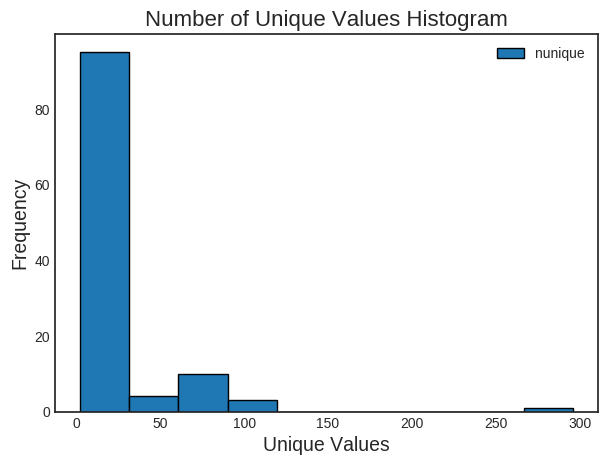

In [90]:
# We can plot a histogram of the number of unique values in each category:
fs.plot_unique()
plt.show()

#### Minimum Redundancy Maximum Relevance Feature selection based on mutual information 

criteria of max-dependency, max-relevance, and min-redundancy.


In [ ]:
pymrmr.mRMR(X_train, 'MIQ', 30)

In [ ]:
pymrmr.mRMR(X_train, 'MID', 30)

#### Relief algorithm and Coalition Game Theory

In [ ]:
%%time
fs = ReliefF(n_features_to_select=len(feature_names))
fs.fit(X_train.values, y_train.values)

In [ ]:
d = dict(zip(X_train.columns, fs.feature_importances_))
d_sorted_by_value = OrderedDict(sorted(d.items(), key=lambda x: -x[1]))

for feature_name, feature_score in d_sorted_by_value.items():
    print("%-25s\t%s"% (feature_name, feature_score))

In [ ]:
%%time
fs = TuRF(core_algorithm="ReliefF", n_features_to_select=30, pct=0.5,verbose=True)
fs.fit(X_train.values, y_train.values, list(X_train.columns))

In [ ]:
d = dict(zip(X_train.columns, fs.feature_importances_))
d_sorted_by_value = OrderedDict(sorted(d.items(), key=lambda x: -x[1]))

for feature_name, feature_score in d_sorted_by_value.items():
    print "%-25s\t%s"% (feature_name, feature_score)

In [ ]:
# To sort features by decreasing score along with their names, 
# and simultaneously indicate which features have been assigned a token TuRF feature score 
# (since they were removed from consideration at some point) 
scoreDict=dict(zip(X_train.columns, fs.feature_importances_))
scored_features = len(fs.top_features_)
sorted_names = sorted(scoreDict, key=lambda x: scoreDict[x], reverse=True)

n = 1

for k in sorted_names:
    if n < scored_features +1 :
        print("%-25s\t%s\t%s" % (str(k), str(scoreDict[k]), str(n)))
    else:
        print("%-25s\t%s\t*"% (str(k), str(scoreDict[k])))
    n += 1

In [ ]:
%%time
fs = TuRF(core_algorithm="SURF", n_features_to_select=30, pct=0.5,verbose=True)
fs.fit(X_train.values, y_train.values, headers)

In [ ]:
%%time
fs = TuRF(core_algorithm="SURFstar", n_features_to_select=30, pct=0.5,verbose=True)
fs.fit(X_train.values, y_train.values, headers)

In [ ]:
%%time
fs = TuRF(core_algorithm="SURF", n_features_to_select=30, pct=0.5,verbose=True)
fs.fit(X_train.values, y_train.values, headers)

In [ ]:
%%time
fs = TuRF(core_algorithm="MultiSURF", n_features_to_select=30, pct=0.5,verbose=True)
fs.fit(X_train.values, y_train.values, headers)

In [ ]:
%%time
fs = TuRF(core_algorithm="MultiSURFstar", n_features_to_select=30, pct=0.5,verbose=True)
fs.fit(X_train.values, y_train.values, headers)

In [ ]:
print('DONE')

## Regularized linear regressions

- Linear regresssion (no regularization)
- Ridge regression (L2-norm)
- LASSO regression (L1-norm)
- Elasticnet regression (combination of L1 and L2 penalties)
- Bayesian regression (L2-norm with Gaussian prior)
-  Least Angle regression (LAR)


### Linear Regression with Lasso regularization (L1 penalty)

In [115]:
alphas_lasso = [1e-6, 1e-5, 0.00005, 0.0001, 0.0005, 0.001, 0.01, 0.03, 0.06, 0.09, 0.1, 0.15] 
lassoCV = LassoCV(alphas=alphas_lasso)

In [116]:
lassoCV.fit(X_train, y_train)

/home/chrisjcc/.local/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


LassoCV(alphas=[1e-06, 1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.01, 0.03, 0.06, 0.09, 0.1, 0.15],
    copy_X=True, cv=None, eps=0.001, fit_intercept=True, max_iter=1000,
    n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [117]:
alpha = lassoCV.alpha_
print("Best Lasso alpha:", alpha)

Best Lasso alpha: 0.0001


In [ ]:
lasso = Lasso(alphas=0.0001)

In [ ]:
lasso.fit(X_train, y_train)

In [118]:
print("RMSE on Training set :", rmse_cv(lasso, X_train, y_train).mean())
print("RMSE on Test set :", rmse_cv(lasso, X_test, y_test).mean())

Ridge RMSE on Training set : 1.5615613144848972
Ridge RMSE on Test set : 1.5189590201703804


In [119]:
predictions = lasso.predict(X_test)
print(explained_variance_score(predictions, y_test))

# Calculate the Root Mean Squared Error
print("RMSE: %.3f"
      % math.sqrt(np.mean((lasso.predict(X_test) - y_test) ** 2)))

-5.900803000125352
RMSE: 1.520


In [120]:
scoring = 'neg_mean_squared_error'
kfold = KFold(n_splits=5, random_state=seed)
cv_results = cross_val_score(lasso,
                             X, y,
                             cv=kfold,
                             scoring=scoring)

In [121]:
print('RMSE: %.3f (%.3f)' % (cv_results.mean(), cv_results.std()))

RMSE: -2.413 (0.358)


In [122]:
pred_train = lasso.predict(X_train)
pred_test  = lasso.predict(X_test)

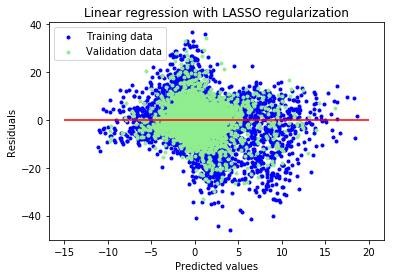

In [271]:
# Plot residuals
plt.scatter(pred_train, pred_train - y_train, 
            c = "blue", marker = ".", label = "Training data")
plt.scatter(pred_test, pred_test - y_test, 
            c = "lightgreen", marker = ".", label = "Validation data")
plt.title("Linear regression with LASSO regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = -15, xmax = 20, color = "red")
plt.show()

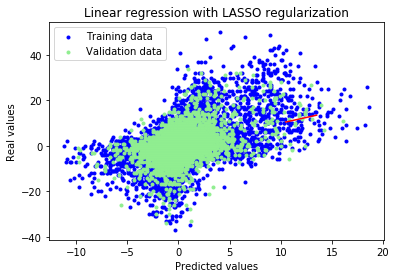

In [272]:
# Plot predictions
plt.scatter(pred_train, y_train, c = "blue", marker = ".", label = "Training data")
plt.scatter(pred_test, y_test, c = "lightgreen", marker = ".", label = "Validation data")
plt.title("Linear regression with LASSO regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

LASSO picked 76 features and eliminated the other 37 features


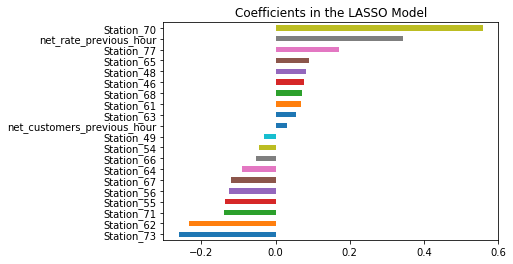

In [228]:
# Plot important coefficients
coefs = pd.Series(lasso.coef_, index = X_train.columns)
print("LASSO picked " + str(sum(coefs != 0)) + \
      " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the LASSO Model")
plt.show()

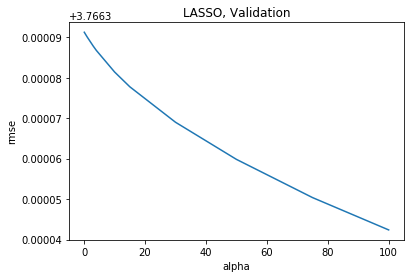


LASSO optimal regularization parameter alpha has rmse = 
3.766342379385031


In [230]:
alphas = [0.05, 0.1, 0.3, 1, 3, 4, 10, 15, 30, 50, 75, 100]

cv_lasso = [rmse_cv(Lasso(alpha=alpha), X_train, y_train).mean() 
            for alpha in alphas
           ]

cv_lasso = pd.Series(np.expm1(cv_ridge), index=alphas)
cv_lasso = pd.Series(cv_ridge, index=alphas)

plt.figure()
cv_lasso.plot(title = "LASSO, Validation")
plt.xlabel('alpha')
plt.ylabel('rmse')
plt.show()
print("\nLASSO optimal regularization parameter alpha has rmse = ")
print(cv_ridge.min())

### Linear Regression with Ridge regularization (L2 penalty)

In [98]:
# Linear Regression with Ridge regularization 
ridgeCV = RidgeCV(alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60])

In [99]:
ridgeCV.fit(X_train, y_train)

RidgeCV(alphas=array([1.e-02, 3.e-02, 6.e-02, 1.e-01, 3.e-01, 6.e-01, 1.e+00, 3.e+00,
       6.e+00, 1.e+01, 3.e+01, 6.e+01]),
    cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
    scoring=None, store_cv_values=False)

In [100]:
alpha = ridgeCV.alpha_
print("Best alpha :", alpha)

Best alpha : 60.0


In [ ]:
ridge = Ridge(alphas=60.0)

In [ ]:
ridge.fit(X_train, y_train)

In [256]:
print("RMSE on Training set :", rmse_cv(ridge, X_train, y_train).mean())
print("RMSE on Test set :", rmse_cv(ridge, X_test, y_test).mean())

RMSE on Training set : 1.561582036787125
RMSE on Test set : 1.51881918747646


In [103]:
predictions = ridge.predict(X_test)
print(explained_variance_score(predictions, y_test))

# Calculate the Root Mean Squared Error
print("RMSE: %.3f"
      % math.sqrt(np.mean((ridge.predict(X_test) - y_test) ** 2)))

-5.890025802054309
RMSE: 1.52


In [104]:
scoring = 'neg_mean_squared_error'
kfold = KFold(n_splits=5, random_state=seed)
cv_results = cross_val_score(ridge,
                             X, y,
                             cv=kfold,
                             scoring=scoring)

%f\%f -2.412565727085706 0.3583730437823607


In [107]:
print('RMSE: %.3f (%.3f)' % (cv_results.mean(), cv_results.std()))

RMSE: -2.413 (0.358)


In [108]:
pred_train = ridge.predict(X_train)
pred_test  = ridge.predict(X_test)

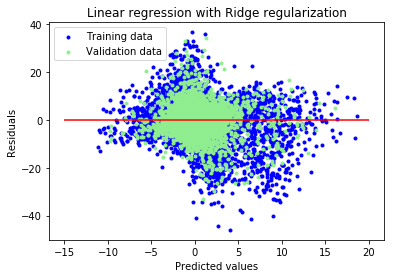

In [274]:
# Plot residuals
plt.scatter(pred_train, pred_train - y_train, 
            c = "blue", marker = ".", label = "Training data")
plt.scatter(pred_test, pred_test - y_test, 
            c = "lightgreen", marker = ".", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = -15, xmax = 20, color = "red")
plt.show()

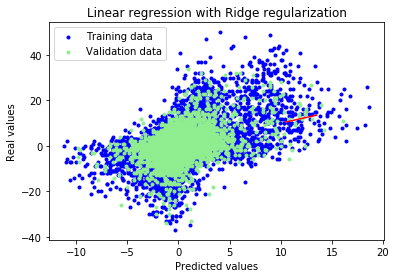

In [275]:
# Plot predictions
plt.scatter(pred_train, y_train, c = "blue", marker = ".", label = "Training data")
plt.scatter(pred_test, y_test, c = "lightgreen", marker = ".", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

Ridge picked 113 features and eliminated the other 0 features


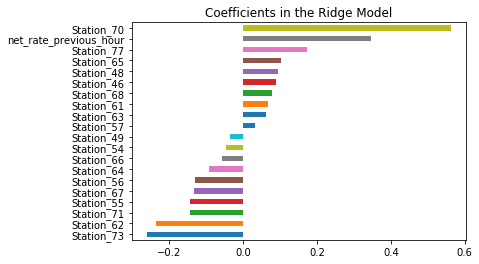

In [111]:
# Plot important coefficients
coefs = pd.Series(ridge.coef_, index = X_train.columns)
print("Ridge picked " + str(sum(coefs != 0)) + \
      " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")
plt.show()

### Linear Regression with ElasticNet regularization (L1 and L2 penalty)

In [112]:
elasticNetCV = ElasticNetCV(l1_ratio = [0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 
                                    0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                          max_iter = 50000, cv = 10)

In [113]:
elasticNetCV.fit(X_train, y_train)

ElasticNetCV(alphas=[0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6],
       copy_X=True, cv=10, eps=0.001, fit_intercept=True,
       l1_ratio=[0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1],
       max_iter=50000, n_alphas=100, n_jobs=1, normalize=False,
       positive=False, precompute='auto', random_state=None,
       selection='cyclic', tol=0.0001, verbose=0)

In [114]:
alpha = elasticNetCV.alpha_
ratio = elasticNetCV.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

Best l1_ratio : 0.7
Best alpha : 0.0003


In [133]:
elasticNet = ElasticNet(l1_ratio=0.7,alpha=0.0003)

In [134]:
elasticNet.fit(X_train, y_train)

ElasticNet(alpha=0.0003, copy_X=True, fit_intercept=True, l1_ratio=0.7,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [135]:
print("RMSE on Training set :", rmse_cv(elasticNet, X_train, y_train).mean())
print("Test set :", rmse_cv(elasticNet, X_test, y_test).mean())

RMSE on Training set : 1.5615458528338315
Test set : 1.5187515347083804


In [136]:
predictions = elasticNet.predict(X_test)
print(explained_variance_score(predictions, y_test))

# Calculate the Root Mean Squared Error
print("RMSE: %.3f"
      % math.sqrt(np.mean((elasticNet.predict(X_test) - y_test) ** 2)))

-5.917798807060603
RMSE: 1.520


In [137]:
scoring = 'neg_mean_squared_error'
kfold = KFold(n_splits=5, random_state=seed)
cv_results = cross_val_score(elasticNet,
                             X, y,
                             cv=kfold,
                             scoring=scoring)

In [138]:
print('RMSE: %.3f (%.3f)' % (cv_results.mean(), cv_results.std()))

RMSE: -2.413 (0.358)


In [139]:
pred_train = elasticNet.predict(X_train)
pred_test  = elasticNet.predict(X_test)

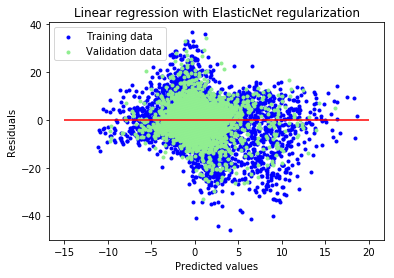

In [276]:
# Plot residuals
plt.scatter(pred_train, pred_train - y_train, c = "blue", marker = ".", label = "Training data")
plt.scatter(pred_test, pred_test - y_test, c = "lightgreen", marker = ".", label = "Validation data")
plt.title("Linear regression with ElasticNet regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = -15, xmax = 20, color = "red")
plt.show()

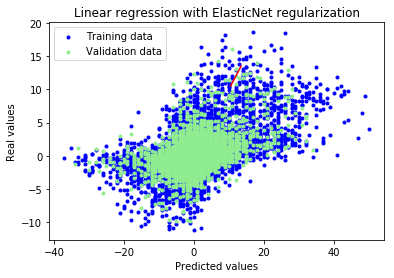

In [277]:
# Plot predictions
plt.scatter(y_train, pred_train, c = "blue", marker = ".", label = "Training data")
plt.scatter(y_test, pred_test, c = "lightgreen", marker = ".", label = "Validation data")
plt.title("Linear regression with ElasticNet regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

ElasticNet picked 54 features and eliminated the other 59 features


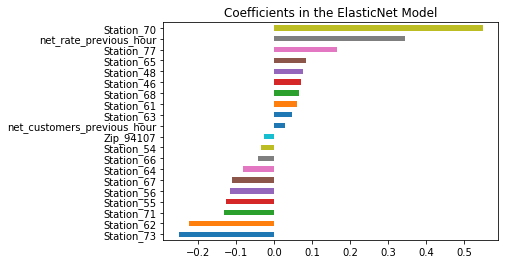

In [142]:
# Plot important coefficients
coefs = pd.Series(elasticNet.coef_, index = X_train.columns)
print("ElasticNet picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                       coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the ElasticNet Model")
plt.show()

The optimal L1 ratio used by ElasticNet here is equal to 1, which means it is exactly equal to the Lasso regressor we used earlier (and had it been equal to 0, it would have been exactly equal to our Ridge regressor). The model didn't need any L2 regularization to overcome any potential L1 shortcoming.

### Linear regression with Bayesian Ridge regularization

In [143]:
bayes = BayesianRidge()

In [144]:
bayes.fit(X_train, y_train)

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, tol=0.001, verbose=False)

In [86]:
predictions = bayes.predict(X_test)
print(explained_variance_score(predictions,y_test))

-5.9073482307392196


In [87]:
# Calculate the Root Mean Squared Error
print("RMSE: %.2f"
      % math.sqrt(np.mean((bayes.predict(X_test) - y_test) ** 2)))

RMSE: 1.52


In [257]:
predictions = bayes.predict(X_test)
print(explained_variance_score(predictions, y_test))

# Calculate the Root Mean Squared Error
print("RMSE: %.3f"
      % math.sqrt(np.mean((bayes.predict(X_test) - y_test) ** 2)))

-5.9073482307392196
RMSE: 1.520


In [258]:
scoring = 'neg_mean_squared_error'
kfold = KFold(n_splits=5, random_state=seed)
cv_results = cross_val_score(bayes,
                             X, y,
                             cv=kfold,
                             scoring=scoring)

In [259]:
print('RMSE: %.3f (%.3f)' % (cv_results.mean(), cv_results.std()))

RMSE: -2.413 (0.358)


In [260]:
pred_train = bayes.predict(X_train)
pred_test  = bayes.predict(X_test)

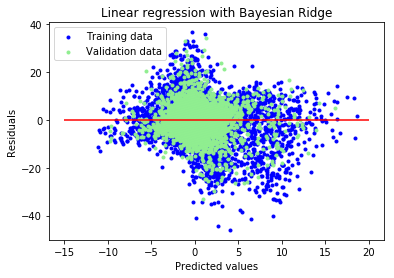

In [278]:
# Plot residuals
plt.scatter(pred_train, pred_train - y_train, c = "blue", marker = ".", label = "Training data")
plt.scatter(pred_test, pred_test - y_test, c = "lightgreen", marker = ".", label = "Validation data")
plt.title("Linear regression with Bayesian Ridge")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = -15, xmax = 20, color = "red")
plt.show()

Text(0.5,1,u'Residual plot in Bayesian Regression')

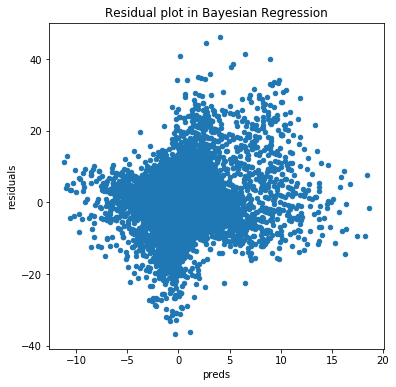

In [279]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
preds = pd.DataFrame({"preds":bayes.predict(X_train), "true":y_train})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")
plt.title("Residual plot in Bayesian Regression")

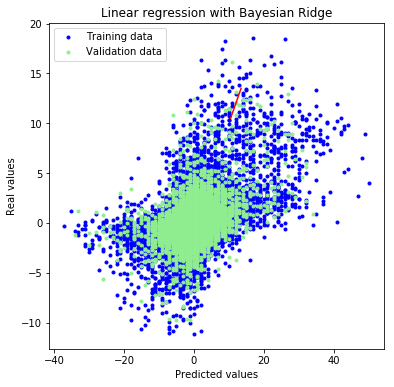

In [280]:
# Plot predictions
plt.scatter(y_train, pred_train, c = "blue", marker = ".", label = "Training data")
plt.scatter(y_test, pred_test, c = "lightgreen", marker = ".", label = "Validation data")
plt.title("Linear regression with Bayesian Ridge")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

Bayesian picked 113 features and eliminated the other 0 features


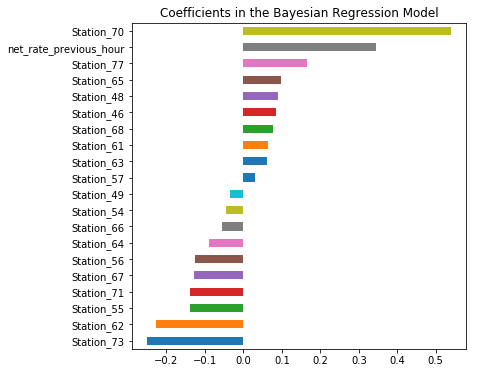

In [281]:
# Plot important coefficients
coefs = pd.Series(bayes.coef_, index = X_train.columns)
print("Bayesian picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                       coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Bayesian Regression Model")
plt.show()

In [ ]:
col={'Train Error':train_error,'Test Error':test_error}
models=['Ridge Regression','Linear Regression','Elastic Net regression',
        'Bayesian Regression',
        'Random Forest','Gradient Boosting', '']
df_comparison=DataFrame(data=col,index=models)
df_comparison

In [ ]:
df_comparison.plot(kind='bar')

### Least Angle regression (LARs)

In [178]:
lars = Lars(n_nonzero_coefs=50)

In [179]:
lars.fit(X_train, y_train)

Lars(copy_X=True, eps=2.220446049250313e-16, fit_intercept=True,
   fit_path=True, n_nonzero_coefs=50, normalize=True, positive=False,
   precompute='auto', verbose=False)

In [180]:
print("RMSE on Training set :", rmse_cv(lars, X_train, y_train).mean())
print("Test set :", rmse_cv(lars, X_test, y_test).mean())

RMSE on Training set : 1.5615339290775883
Test set : 1.518630596093183


In [181]:
predictions = lars.predict(X_test)
print(explained_variance_score(predictions, y_test))

# Calculate the Root Mean Squared Error
print("RMSE: %.3f"
      % math.sqrt(np.mean((lars.predict(X_test) - y_test) ** 2)))

-5.932379556140372
RMSE: 1.519


In [182]:
scoring = 'neg_mean_squared_error'
kfold = KFold(n_splits=5, random_state=seed)
cv_results = cross_val_score(lars,
                             X, y,
                             cv=kfold,
                             scoring=scoring)

In [183]:
print('RMSE: %.3f (%.3f)' % (cv_results.mean(), cv_results.std()))

RMSE: -2.413 (0.358)


In [184]:
pred_train = lars.predict(X_train)
pred_test  = lars.predict(X_test)

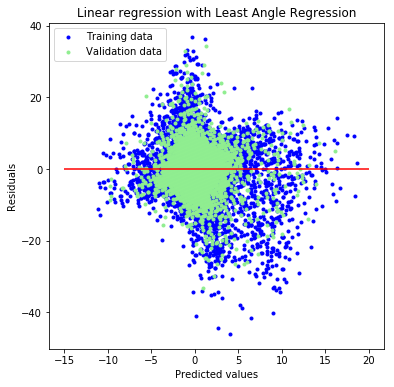

In [282]:
# Plot residuals
plt.scatter(pred_train, pred_train - y_train, 
            c = "blue", marker = ".", label = "Training data")
plt.scatter(pred_test, pred_test - y_test, 
            c = "lightgreen", marker = ".", label = "Validation data")
plt.title("Linear regression with Least Angle Regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = -15, xmax = 20, color = "red")
plt.show()

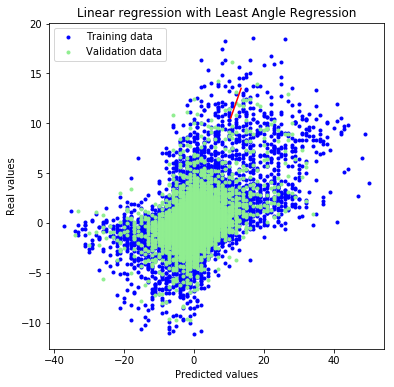

In [283]:
# Plot predictions
plt.scatter(y_train, pred_train, c = "blue", marker = ".", label = "Training data")
plt.scatter(y_test, pred_test, c = "lightgreen", marker = ".", label = "Validation data")
plt.title("Linear regression with Least Angle Regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

LARS picked 50 features and eliminated the other 63 features


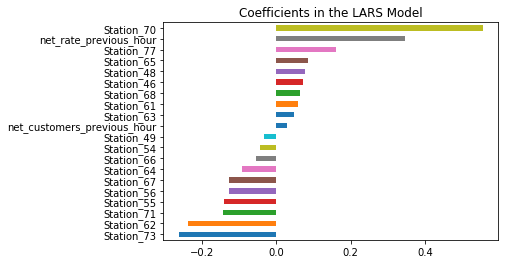

In [239]:
# Plot important coefficients
coefs = pd.Series(lars.coef_, index = X_train.columns)
print("LARS picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the LARS Model")
plt.show()

## Tree-based regression

### Random Forest Regressor

In [190]:
rfr = RandomForestRegressor(n_jobs=1, criterion='mse', random_state=42)

In [191]:
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [192]:
predictions = rfr.predict(X_test)
print(explained_variance_score(predictions,y_test))

0.06337285676605475


In [193]:
# Calculate the Root Mean Squared Error
print("RMSE: %.2f"
      % math.sqrt(np.mean((rfr.predict(X_test) - y_test) ** 2)))

RMSE: 1.22


In [194]:
scoring = 'neg_mean_squared_error'
kfold = KFold(n_splits=5, random_state=seed)
cv_results = cross_val_score(rfr,
                             X, y,
                             cv=kfold,
                             scoring=scoring)

In [195]:
print('RMSE: %.3f (%.3f)' % (cv_results.mean(), cv_results.std()))

RMSE: -1.607 (0.160)


In [196]:
pred_train = rfr.predict(X_train)
pred_test  = rfr.predict(X_test)

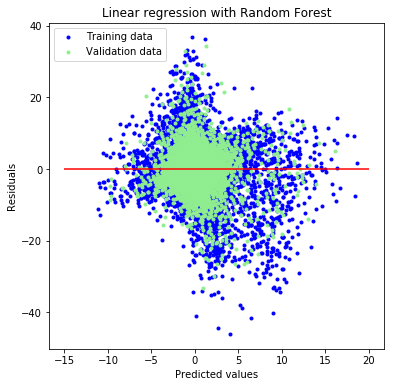

In [285]:
# Plot residuals
plt.scatter(pred_train, pred_train - y_train, 
            c = "blue", marker = ".", label = "Training data")
plt.scatter(pred_test, pred_test - y_test, 
            c = "lightgreen", marker = ".", label = "Validation data")
plt.title("Linear regression with Random Forest")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = -15, xmax = 20, color = "red")
plt.show()

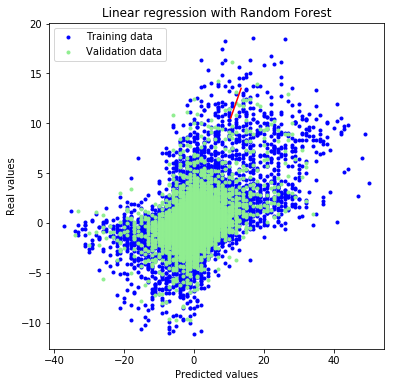

In [286]:
# Plot predictions
plt.scatter(y_train, pred_train, c = "blue", marker = ".", label = "Training data")
plt.scatter(y_test, pred_test, c = "lightgreen", marker = ".", label = "Validation data")
plt.title("Linear regression with Random Forest")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

RandomForest picked 113 features and eliminated the other 0 features


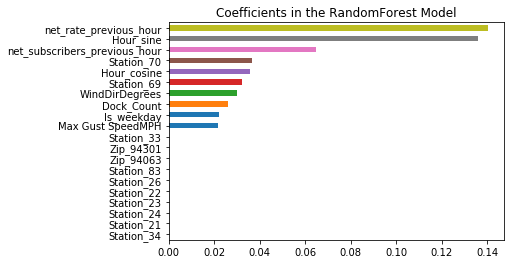

In [243]:
# Plot important coefficients
coefs = pd.Series(rfr.feature_importances_, index = X_train.columns)
print("RandomForest picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                       coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the RandomForest Model")
plt.show()

### Gradient Boosting Regressor

In [201]:
## Fitting Gradient Boosting Regressor

# Hyper-parameter optimization and model evaluation using nested cross-validation
gbr = GradientBoostingRegressor(criterion='friedman_mse', 
                                subsample=0.80,
                                max_features='auto',
                                random_state=42)

In [202]:
gbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             n_iter_no_change=None, presort='auto', random_state=42,
             subsample=0.8, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [203]:
predictions = gbr.predict(X_test)
print(explained_variance_score(predictions,y_test))

-2.2648569796923623


In [204]:
# Calculate the Root Mean Squared Error
print("RMSE: %.2f"
      % math.sqrt(np.mean((gbr.predict(X_test) - y_test) ** 2)))

RMSE: 1.37


In [206]:
scoring = 'neg_mean_squared_error'
kfold = KFold(n_splits=5, random_state=seed)
cv_results = cross_val_score(gbr,
                             X, y,
                             cv=kfold,
                             scoring=scoring)

In [207]:
print('RMSE: %.3f (%.3f)' % (cv_results.mean(), cv_results.std()))

RMSE: -1.966 (0.305)


In [208]:
pred_train = gbr.predict(X_train)
pred_test  = gbr.predict(X_test)

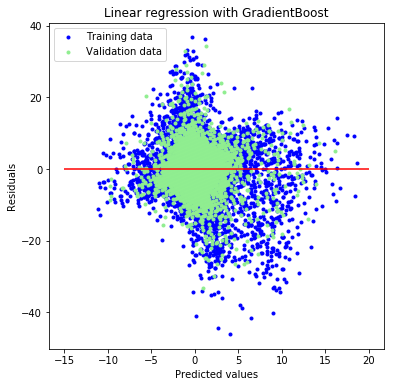

In [291]:
# Plot residuals
plt.scatter(pred_train, pred_train - y_train, 
            c = "blue", marker = ".", label = "Training data")
plt.scatter(pred_test, pred_test - y_test, 
            c = "lightgreen", marker = ".", label = "Validation data")
plt.title("Linear regression with GradientBoost")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = -15, xmax = 20, color = "red")
plt.show()

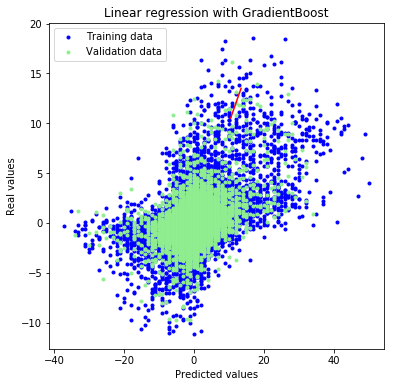

In [290]:
# Plot predictions
plt.scatter(y_train, pred_train, c = "blue", marker = ".", label = "Training data")
plt.scatter(y_test, pred_test, c = "lightgreen", marker = ".", label = "Validation data")
plt.title("Linear regression with GradientBoost")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

XGBoost picked 46 features and eliminated the other 67 features


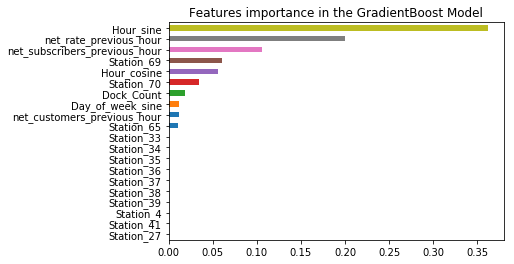

In [252]:
# Plot important coefficients
coefs = pd.Series(gbr.feature_importances_, index = X_train.columns)
print("XGBoost picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                       coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Features importance in the GradientBoost Model")
plt.show()

### XGBoost Regressor

In [213]:
## Fitting XGBoost regressor

# Hyper-parameter optimization and model evaluation using nested cross-validation
xgbr = XGBRegressor()

In [214]:
xgbr.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [215]:
predictions = xgbr.predict(X_test)
print(explained_variance_score(predictions,y_test))

-2.495030802232896


In [221]:
# Calculate the Root Mean Squared Error
print("RMSE: %.2f"
      % math.sqrt(np.mean((xgbr.predict(X_test) - y_test) ** 2)))

RMSE: 1.38


In [222]:
scoring = 'neg_mean_squared_error'
kfold = KFold(n_splits=5, random_state=seed)
cv_results = cross_val_score(xgbr,
                             X, y,
                             cv=kfold,
                             scoring=scoring)

In [223]:
print('RMSE: %.3f (%.3f)' % (cv_results.mean(), cv_results.std()))

RMSE: -1.953 (0.302)


In [224]:
pred_train = xgbr.predict(X_train)
pred_test  = xgbr.predict(X_test)

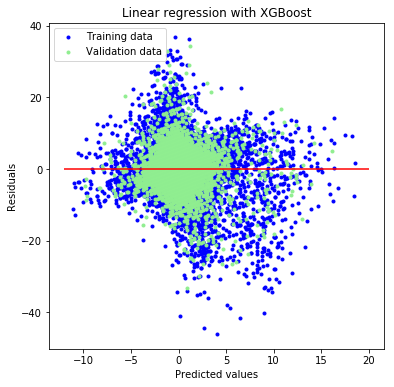

In [293]:
# Plot residuals
plt.scatter(pred_train, pred_train - y_train, 
            c = "blue", marker = ".", label = "Training data")
plt.scatter(pred_test, pred_test - y_test, 
            c = "lightgreen", marker = ".", label = "Validation data")
plt.title("Linear regression with XGBoost")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = -12, xmax = 20, color = "red")
plt.show()

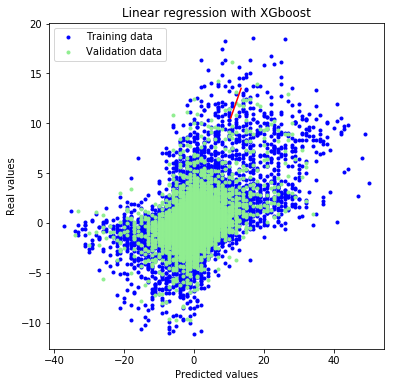

In [294]:
# Plot predictions
plt.scatter(y_train, pred_train, c = "blue", marker = ".", label = "Training data")
plt.scatter(y_test, pred_test, c = "lightgreen", marker = ".", label = "Validation data")
plt.title("Linear regression with XGboost")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

XGBoost picked 38 features and eliminated the other 75 features


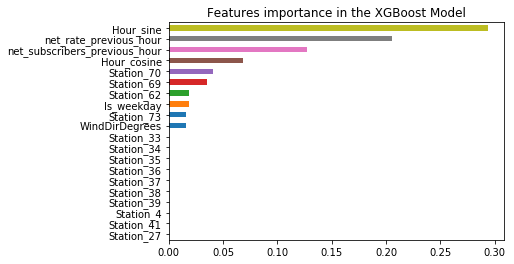

In [253]:
# Plot important coefficients
coefs = pd.Series(xgbr.feature_importances_, index = X_train.columns)
print("XGBoost picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                       coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Features importance in the XGBoost Model")
plt.show()

#### Regression model comparison

By comapring several different regressoin alorithm we can establish the baseline model for further study and improvement, e.g. model interpretation and optimization.

In [296]:
%%time
# Prepare models
models = []
models.append(('linear', LinearRegression()))
models.append(('lasso', Lasso()))
models.append(('ridge', Ridge()))
models.append(('elasticnet', ElasticNet()))
models.append(('bayesridge', BayesianRidge()))
models.append(('lars', Lars(n_nonzero_coefs=50)))
models.append(('randomforest', RandomForestRegressor()))
models.append(('gradientboost', GradientBoostingRegressor()))
models.append(('xgboost', XGBRegressor()))

# Evaluate each model in turn
results = []
names = []
scoring = 'neg_mean_squared_error'

for name, model in models:

    kfold = KFold(n_splits=5, random_state=seed)
    
    cv_results = cross_val_score(model,
                                 X, y,
                                 cv=kfold,
                                 scoring=scoring)
    results.append((-1)*cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, (-1)*cv_results.mean(), cv_results.std())
    print(msg)

linear: 2.412573 (0.358363)
lasso: 2.750812 (0.425077)
ridge: 2.412573 (0.358363)
elasticnet: 2.544715 (0.391961)
bayesridge: 2.412553 (0.358421)
lars: 8167778.815773 (16334887.364255)
randomforest: 1.617276 (0.169076)
gradientboost: 1.955099 (0.302380)
xgboost: 1.953094 (0.301876)
CPU times: user 35min 48s, sys: 5min 23s, total: 41min 12s
Wall time: 28min 5s


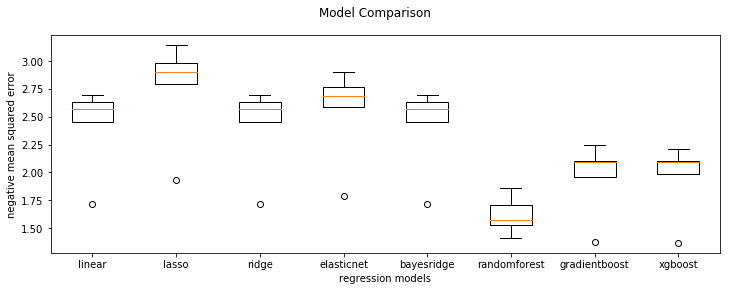

In [96]:
# Boxplot algorithm comparison
fig = plt.figure(figsize=(12,4))
fig.suptitle('Model Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names) 
ax.set_ylabel('Mean squared error')
ax.set_xlabel('Regression models')
plt.show()

From these results, it would suggest that randomforest regression (best performing), gradientboost, and xgboost analysis are perhaps worthy of further study on this problem.

If some of the covariates are highly correlated, one may want to look at the Elastic Net instead of the LASSO, does both parameter shrinkage and variable selection automatically, while Ridge regression can't zero out parameter coefficients estimates.

### Learning Curves

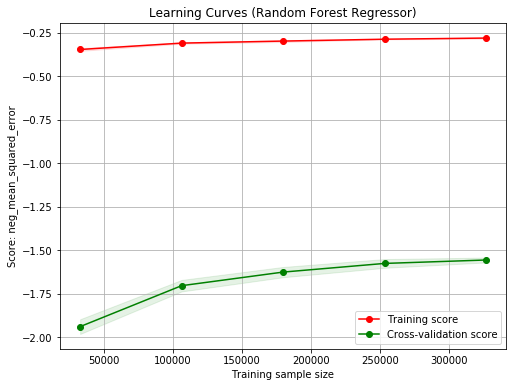

None

In [297]:
# Check if the model would benefit from data
pipe = make_pipeline(rfr)

title = "Learning Curves (Random Forest Regressor)"

plot_learning_curve(pipe, title, X_train, y_train, 
                    cv=None, 
                    scoring='neg_mean_squared_error', 
                    n_jobs=1,
                    train_sizes=np.linspace(.1, 1.0, 5))

Investigate the variational gap.

### Model tuning with Bayesian Optimization

In [ ]:
estimator = rfr

In [ ]:
# Number of iterations
n_calls = 11

# K-fold stratified cross-validaiton
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)

In [ ]:
# Configuration space
space  = [
    Integer(50,   100,                     name='kerasclassifier__n_estimators'),
    Integer(1,   15,                       name='kerasclassifier__max_depth'),
    Real(10**-3, 9.*10**-1, "log-uniform", name='kerasclassifier__gamma'),
    Real(10**-3, 9.*10**-1, "log-uniform", name='kerasclassifier__learning_rate'),
    Real(10**-3, 10**-1,    "log-uniform", name='kerasclassifier__gamma')    
]

In [ ]:
# Objective function
@use_named_args(space)
def objective(**params):

    model.set_params(**params)
    
    score = -np.mean(cross_val_score(estimator,
                                     X, y,
                                     cv=cv, scoring='r2_score f'))

    return score

In [ ]:
print('Processing Bayesian optimization...')

# Bayesian optimization based on Gaussian process regression search (controlling the exploration-exploitation trade-off)
estimator_gp_ei = gp_minimize(func=objective,           # the function to minimize
                              dimensions=space,         # the bounds on each dimension of the optimization space
                              acq_func="EI",            # the acquisition function ("EI", "LCB", "PI")
                              n_calls=n_calls,          # the number of evaluations of the objective function (Number of calls to func)
                              random_state=seed,        # the random seed  
                              #x0=default_parameters,    # help the optimizer locate better hyper-parameters faster with default values
                              n_jobs=1)                 # the number of threads to use

In [ ]:
print("Best score=%.4f (EI)" % estimator_gp_ei.fun)
print("""Expected Improvement (EI) best parameters:
- nlayers= %s  
- nneurons= %s
- l2_norm= %s
- dropout_rate= %s""" % (str(estimator_gp_ei.x[0]), str(estimator_gp_ei.x[1]),
                         str(estimator_gp_ei.x[2]), str(estimator_gp_ei.x[3])))

In [ ]:
# Evalution
plot_evaluations(gp_ei, bins=10, 
                 dimensions=['n_layers', 'n_neurons', 'l2_norm', 'dropout_rate'])
plt.show()

In [ ]:
# Convergence (previously looked better enquire what is going on)
plot_convergence(gp_ei);
plt.show()

## Model interpretability

Model interpretability with SHapley Additive exPlanations a Coalition Game Theory approach

In [299]:
# load JS in order to use some of the plotting functions from the shap
# package in the notebook
shap.initjs()

In [ ]:
# Set estimator
estimator = rfr

# create our SHAP explainer
shap_explainer = shap.TreeExplainer(estimator)

# calculate the shapley values for our test set
test_shap_vals = shap_explainer.shap_values(X_test)

In [ ]:
# plot the explanation for a single prediction
shap.force_plot(shap_explainer.expected_value, test_shap_vals[30, :], X_test.iloc[30, :])

In [ ]:
# Plot the distribution of each feature's SHAP 
shap.summary_plot(test_shap_vals, X_test, auto_size_plot=False)

In [ ]:
for feat in feature_names:
    shap.dependence_plot(feat, test_shap_vals, X_test, 
                         dot_size=100)

In [ ]:
def shapley(row):
    s_df = pd.DataFrame(shap_values[row.index[0], :][:-1].reshape(23, 1), columns=['Approximate Local Contributions'], index=X)
    s_df = s_df.sort_values(by='Approximate Local Contributions')
    print(s_df, '\n')
    _= s_df.plot(kind='bar', title='Approximate Local Contributions', legend=False)
    print('Shapley sum: ', s_df['Approximate Local Contributions'].sum() + shap_values[row.index[0], -1])
    p = row['predict'].values[0]
    print('Model prediction: ', np.log(p/(1 - p)))

In [ ]:
xgb_preds = pd.DataFrame(xgb_model.predict(X_test)) # or dtest

In [ ]:
decile_frame = pd.concat([y_test, xgb_preds], axis=1)
decile_frame = decile_frame.rename(columns={0: 'predict'})

In [ ]:
decile = 10
row = decile_frame

In [ ]:
shapley(row)

### Conclusions

We have modeld the problem using Random forest regressor which had an RMSE of 2.81 and it performed better than Gradient boosting. Given more time I would have delved more into which features had the greatest predictive power.

### Potential Improvements

We can attempt to use external data to improve our modeling. This data provides estimated yearly pedestrian volume at each intersection. Using the volumne of pedestrian near the bike station may help to anticipate the demand on bike rental.

url: https://catalog.data.gov/dataset/pedestrian-volume-model-data-2011-study
        
A. PURPOSE
This dataset is created to show the estimated yearly pedestrian volume at each intersection. 

B. METHODOLOGY 
http://archives.sfmta.com/cms/rpedmast/documents/FinalPedestrianCountReport6_17_11.pdf 
C. UPDATE FREQUENCY
Not updated 

D. OTHER CRITICAL INFO
Volume estimates made with 2011 transportation data and 2000 US Census data 

E. ATTRIBUTES

- CNN: San Francisco's street centerline network unique ID; 
- ST_NAME1: Name of cross street;
- ST_TYPE1: Type of street;
- ST_NAME2: Name of cross street;
- ST_TYPE2: Type of street;
- ST_NAME3: Name of cross street;
- ST_TYPE3: Type of street;
- ST_NAME4: Name of cross street;
- ST_TYPE4: Type of street;
- TOTEMP2: Total number of jobs within 0.25 miles of the intersection in 2010. Data calculated by SFCTA from SFCTA traffic analysis zones. These data are produced by the SF Planning Department by allocating ABAG county‐level land use figures to the SFCTA's 981 transportation analysis zones within San Francisco;
- UNIVPROX: Intersection is located within 0.25 miles of one the five major university campuses in the city: USF Lone Mountain, UCSF Parnassus, UCSF Mission Bay, City College Ingleside, SFSU Park Merced. Other schools are not included, since they are either smaller, more spread out, or different in character (e.g., serve adult/commuter students at night). (1 = yes, 0 = no);
- Signalized: Intersection is controlled by a traffic signal. (1 = yes, 0 = no);
- PkgMeters: Intersection is in a zone with parking meters (e.g., parking meters are present on at least one approach to the intersection). (1 = yes, 0 =no);
- MaxPctSlpe: Maximum slope of any approach to the intersection. (Percent slope);
- Model6_Vol: Annual pedestrian volume;
- HH_PedMode: Unknown;PCol_04: Unknown;PCol_Rate: Unknown

Having more time I would have matched these intersections with the bike stations.

In [ ]:
# reverse geocoder library
import reverse_geocoder as rg

# Load datation data
mta_data = pd.read_csv(filepath_or_buffer='data/MTA.pedvolumemodel_data.csv',
                       sep=',')

# Pedestrian volume at different intersections around San Francisco
mta_data[['the_geom', 'MODEL6_VOL']].head(5)